iter 200/2000 counts=[136 144 120] pi=[0.347 0.313 0.34 ]
iter 400/2000 counts=[137 144 119] pi=[0.318 0.389 0.293]
iter 600/2000 counts=[137 143 120] pi=[0.354 0.367 0.279]
iter 800/2000 counts=[136 143 121] pi=[0.338 0.38  0.282]
iter 1000/2000 counts=[136 142 122] pi=[0.337 0.377 0.286]
iter 1200/2000 counts=[137 144 119] pi=[0.367 0.354 0.279]
iter 1400/2000 counts=[135 144 121] pi=[0.329 0.355 0.316]
iter 1600/2000 counts=[136 144 120] pi=[0.356 0.359 0.285]
iter 1800/2000 counts=[137 144 119] pi=[0.358 0.404 0.238]
iter 2000/2000 counts=[137 144 119] pi=[0.35  0.333 0.317]

Posterior mean of pi: [0.34070531 0.36043095 0.29886374]
Posterior mean of mus:
 [[ 4.05331735  3.98906449]
 [-4.03902483  3.94555357]
 [-0.02670326 -0.07508041]]


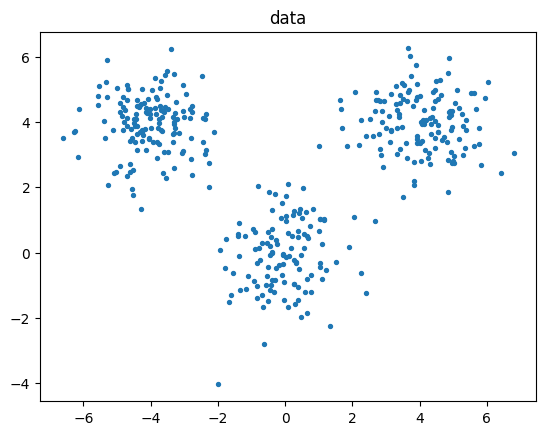

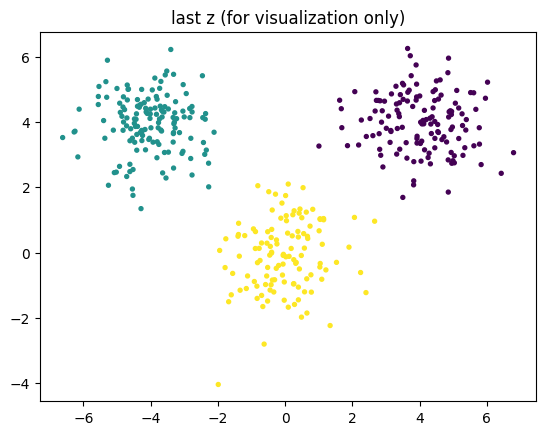

In [1]:
# bayes_gmm_gibbs.py
# pip install numpy scipy matplotlib

import numpy as np
from numpy.linalg import inv, slogdet
from scipy.stats import wishart, multivariate_normal
import matplotlib.pyplot as plt

rng = np.random.default_rng(0)

# ----------------------------
# 0) データ（例：2Dの擬似データ）
# ----------------------------
N = 400
true_means = np.array([[0, 0], [4, 4], [-4, 4]])
true_covs  = np.array([
    [[1.0, 0.2],[0.2, 1.2]],
    [[1.2, -0.1],[-0.1, 0.9]],
    [[0.8, 0.0],[0.0, 0.8]],
])
true_pi = np.array([0.35, 0.35, 0.30])
K_true = len(true_pi)

z_true = rng.choice(K_true, size=N, p=true_pi)
X = np.vstack([rng.multivariate_normal(true_means[k], true_covs[k]) for k in z_true])
D = X.shape[1]

# ----------------------------
# 1) モデル設定（Kは固定）
# ----------------------------
K = 3

# Dirichlet prior for pi
alpha0 = np.ones(K) * 1.0

# NIW prior for (mu, Sigma)
# Sigma ~ Inv-Wishart(nu0, S0)  <=>  Lambda = Sigma^{-1} ~ Wishart(nu0, V0) with V0 = S0^{-1}
m0 = np.zeros(D)
kappa0 = 0.01
nu0 = D + 2
S0 = np.eye(D) * 5.0

# ----------------------------
# 2) 初期化
# ----------------------------
z = rng.integers(0, K, size=N)
pi = rng.dirichlet(alpha0)
mus = rng.normal(0, 1, size=(K, D))
Sigmas = np.array([np.eye(D) for _ in range(K)])

# ----------------------------
# 3) 補助関数：NIWの事後サンプリング
# ----------------------------
def sample_mu_sigma_from_niw(Xk, m0, kappa0, nu0, S0):
    """
    Xk: (nk, D)
    NIW prior: (m0, kappa0, nu0, S0) with Sigma ~ InvWishart(nu0, S0)
    Return sampled (mu, Sigma)
    """
    nk = Xk.shape[0]
    if nk == 0:
        # 事前からサンプル
        # Sample Sigma ~ Inv-Wishart via Wishart on precision
        V0 = inv(S0)
        Lambda = wishart.rvs(df=nu0, scale=V0, random_state=rng)
        Sigma = inv(Lambda)
        mu = rng.multivariate_normal(m0, Sigma / kappa0)
        return mu, Sigma

    xbar = Xk.mean(axis=0)
    # Scatter
    Xc = Xk - xbar
    Sk = Xc.T @ Xc

    kappa_n = kappa0 + nk
    nu_n = nu0 + nk
    m_n = (kappa0 * m0 + nk * xbar) / kappa_n

    # S_n = S0 + Sk + (kappa0*nk/kappa_n) (xbar - m0)(xbar - m0)^T
    diff = (xbar - m0).reshape(-1, 1)
    S_n = S0 + Sk + (kappa0 * nk / kappa_n) * (diff @ diff.T)

    # Sample Sigma ~ Inv-Wishart(nu_n, S_n) via Wishart on precision
    Vn = inv(S_n)
    Lambda = wishart.rvs(df=nu_n, scale=Vn, random_state=rng)
    Sigma = inv(Lambda)

    # Sample mu | Sigma
    mu = rng.multivariate_normal(m_n, Sigma / kappa_n)
    return mu, Sigma

# ----------------------------
# 4) Gibbs Sampling
# ----------------------------
n_iter = 2000
burn_in = 500
thin = 5

trace_pi = []
trace_mu = []

for it in range(n_iter):
    # (A) sample z | pi, mu, Sigma
    logp = np.zeros((N, K))
    for k in range(K):
        logp[:, k] = np.log(pi[k] + 1e-300) + multivariate_normal.logpdf(
            X, mean=mus[k], cov=Sigmas[k], allow_singular=False
        )
    # 正規化してサンプル
    logp -= logp.max(axis=1, keepdims=True)
    p = np.exp(logp)
    p /= p.sum(axis=1, keepdims=True)
    # 各行ごとにカテゴリサンプル
    cum = np.cumsum(p, axis=1)
    u = rng.random(N)
    z = (cum < u[:, None]).sum(axis=1)

    # (B) sample pi | z
    counts = np.bincount(z, minlength=K)
    pi = rng.dirichlet(alpha0 + counts)

    # (C) sample (mu_k, Sigma_k) | z, X
    for k in range(K):
        Xk = X[z == k]
        mus[k], Sigmas[k] = sample_mu_sigma_from_niw(Xk, m0, kappa0, nu0, S0)

    if it >= burn_in and (it - burn_in) % thin == 0:
        trace_pi.append(pi.copy())
        trace_mu.append(mus.copy())

    if (it + 1) % 200 == 0:
        print(f"iter {it+1}/{n_iter} counts={counts} pi={np.round(pi,3)}")

trace_pi = np.array(trace_pi)      # (T, K)
trace_mu = np.array(trace_mu)      # (T, K, D)

print("\nPosterior mean of pi:", trace_pi.mean(axis=0))
print("Posterior mean of mus:\n", trace_mu.mean(axis=0))

# ----------------------------
# 5) 簡易可視化
# ----------------------------
plt.figure()
plt.scatter(X[:,0], X[:,1], s=8)
plt.title("data")
plt.show()

# 最後のサンプルのクラスタ割当で表示（見た目確認用）
plt.figure()
plt.scatter(X[:,0], X[:,1], c=z, s=8)
plt.title("last z (for visualization only)")
plt.show()
